# Les questions doubles

Dans ce notebook, vous explorerez les réseaux siamois appliqués au traitement du langage naturel. Vous explorerez plus avant les principes fondamentaux du Trax et vous serez en mesure de mettre en œuvre une structure plus complexe en l'utilisant. En effectuant ce notebook, vous apprendrez à mettre en œuvre des modèles avec différentes architectures. 

### Vue d'ensemble

Dans le cadre de ce notebook, concrètement, vous allez : 

- Découvrir les réseaux siamois
- Comprendre comment fonctionne la fonction de coût de triplet
- Comprendre comment évaluer la précision d'un modèle siamois
- Utiliser la similarité en cosinus entre les vecteurs produits par le modèle
- Utilisez le générateur de données pour obtenir des lots de questions
- Effectuer des prédictions en utilisant votre propre modèle

Vous êtes maintenant familiarisé avec trax et savez utiliser les classes pour définir votre modèle. Nous commencerons ce devoir en vous demandant de prétraiter les données. Après avoir traité les données, vous construirez un classificateur qui vous permettra d'identifier si les questions sont les mêmes ou non. 


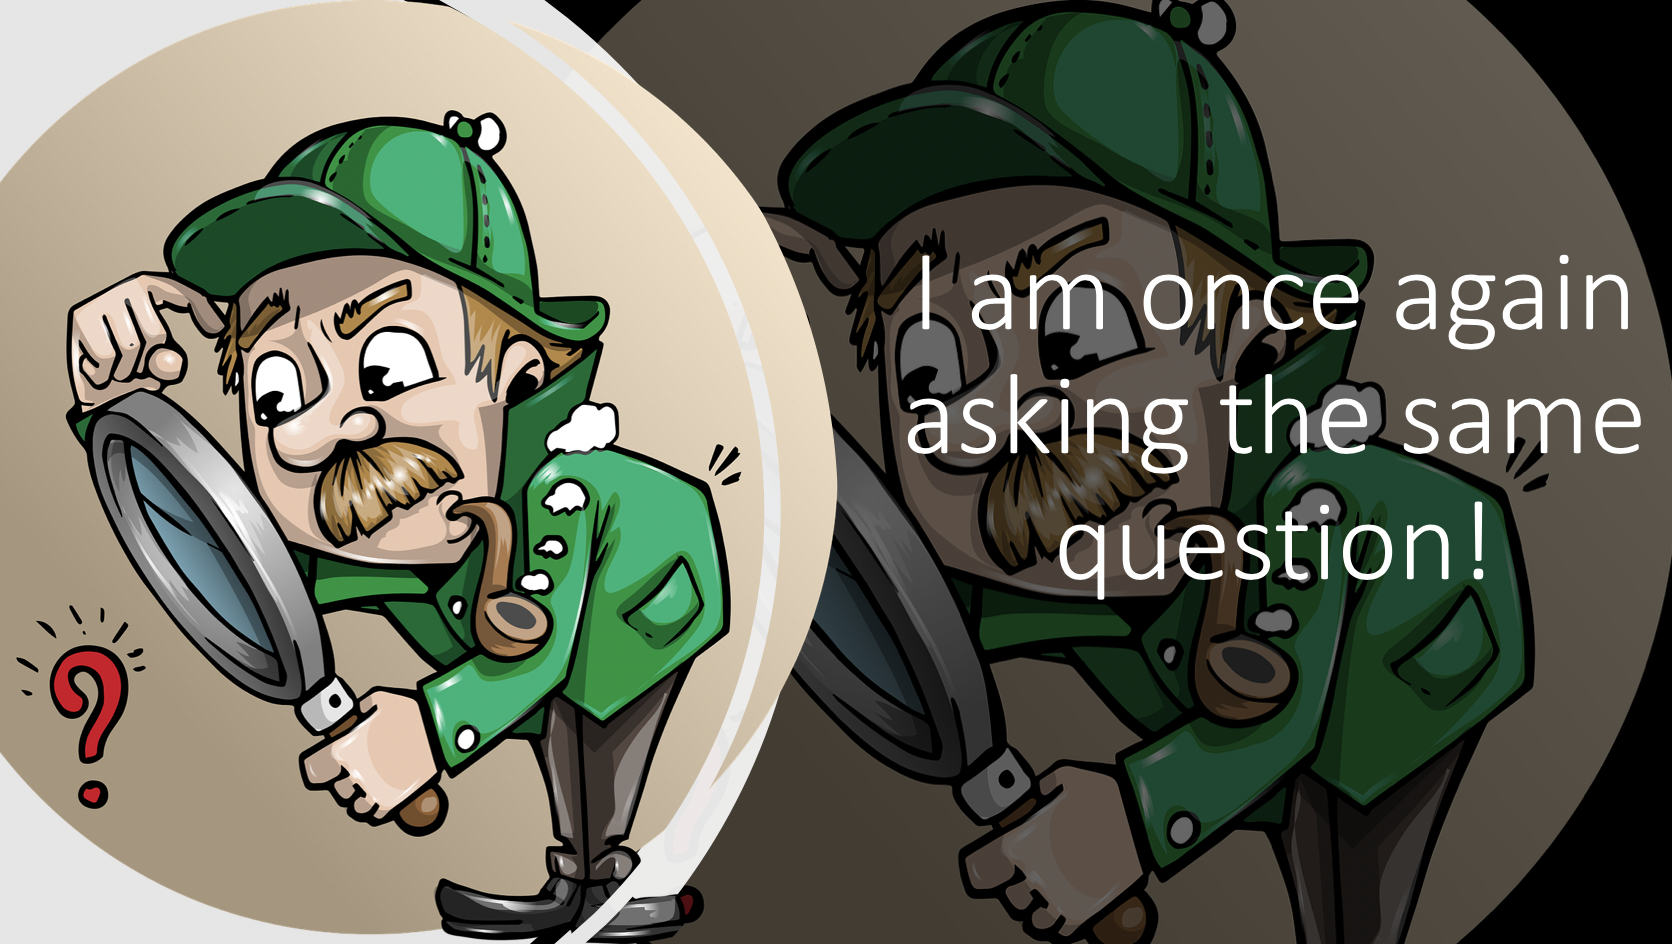

Vous traiterez d'abord les données. Votre modèle prendra en compte les deux questions intégrées, les fera passer par un LSTM, puis comparera les résultats des deux sous-réseaux en utilisant la similarité des cosinus. Avant de vous plonger dans le modèle, commencez par importer l'ensemble des données.



# Partie 1 : Importation des données

### 1.1 Importation de fichiers

Avant de commencer veuillez importer les fichiers du TP via le lien ci-dessous :

https://drive.google.com/drive/folders/1AIma37mPYdP6klxnvFwhO9GwlJAX0A0F?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


### 1.2 Chargement des données

Vous utiliserez l'ensemble des données de Quora pour construire un modèle qui pourrait identifier des questions similaires. C'est une tâche utile car vous ne voulez pas que plusieurs versions de la même question soient affichées. Cet ensemble de données a été étiqueté pour vous. Lancez la cellule ci-dessous pour importer certains des packages que vous utiliserez. 

In [ ]:
!pip install trax

In [ ]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd

# set random seeds
rnd.seed(34)

nltk.download('punkt')

**Notez que pour cette mission, le numpy de Trax est appelée `fastnp`, alors que numpy est régulièrement est appelée `np`.

Vous allez maintenant charger l'ensemble des données. Nous avons effectué un prétraitement pour vous. Il s'agit d'une méthode d'entraînement légèrement différente de celle que vous avez vue. 

In [ ]:
data = pd.read_csv("gdrive/MyDrive/TP_10/questions.csv")
N=len(data)
print('Number of question pairs: ', N)
data.head()

Nous avons d'abord divisé les données en train et test. L'ensemble de test sera utilisé plus tard pour évaluer notre modèle.

In [ ]:
N_train = 300000
N_test  = 10*1024
data_train = data[:N_train]
data_test  = data[N_train:N_train+N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del(data) # remove to free memory

Comme expliqué dans le cours, nous sélectionnons uniquement les paires de questions qui sont dupliquées pour entraîner le modèle. <br>
Nous construisons deux lots comme entrée pour le réseau siamois et nous supposons que la question $q1_i$ (question $i$ dans le premier lot) est un double de $q2_i$ (question $i$ dans le second lot), mais que toutes les autres questions du second lot ne sont pas des doubles de $q1_i$.  
L'ensemble de tests utilise les paires de questions originales et le statut décrivant si les questions sont des doublons.

In [ ]:
td_index = (data_train['is_duplicate'] == 1).to_numpy()
td_index = [i for i, x in enumerate(td_index) if x] 
print('number of duplicate questions: ', len(td_index))
print('indexes of first ten duplicate questions:', td_index[:10])

In [ ]:
print(data_train['question1'][5])  #  Example of question duplicates (first one in data)
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

In [ ]:
Q1_train_words = np.array(data_train['question1'][td_index])
Q2_train_words = np.array(data_train['question2'][td_index])

Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

Vous avez vu ci-dessus que vous n'avez pris que les questions en double pour entraîner notre modèle. <br>Vous l'avez fait exprès, car le générateur de données produira des lots $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$ où $q1_i$ et $q2_k$ sont en double si et seulement si $i = k$.

<br> Imprimons pour voir à quoi ressemblent vos données.

In [ ]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train_words[0])
print('Question 2: ', Q2_train_words[0], '\n')
print('Question 1: ', Q1_train_words[5])
print('Question 2: ', Q2_train_words[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test_words[0])
print('Question 2: ', Q2_test_words[0], '\n')
print('is_duplicate =', y_test[0], '\n')

Vous allez maintenant encoder chaque mot des paires de doublons sélectionnées avec un index. <br> Pour une question donnée, vous pouvez alors simplement l'encoder sous forme de liste de chiffres.  

Tout d'abord, vous devez marquer les questions en utilisant `nltk.word_tokenize`. <br>
Vous avez besoin d'un dictionnaire python par défaut qui, plus tard, lors de l'inférence, attribue les valeurs $0$ à tous les mots hors vocabulaire (OOV).<br>
Ensuite, vous encodez chaque mot des paires de doublons sélectionnées avec un index. Si une question vous est posée, vous pouvez alors simplement l'encoder sous la forme d'une liste de chiffres. 

In [ ]:
#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [ ]:
# Building the vocabulary with the train set         (this might take a minute)
from collections import defaultdict

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

In [ ]:
print(vocab['<PAD>'])
print(vocab['Astrology'])
print(vocab['Astronomy'])  #not in vocabulary, returns 0

In [ ]:
for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [ ]:
print('Train set has reduced to: ', len(Q1_train) ) 
print('Test set length: ', len(Q1_test) ) 

<a name='1.2'></a>
### 1.2 Conversion d'une question en tensor

Vous allez maintenant convertir chaque question en un tensor, ou un tableau de nombres, en utilisant votre vocabulaire construit ci-dessus.

In [ ]:
# Converting questions to array of integers
for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

        
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [ ]:
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

Vous allez maintenant diviser votre train en un ensemble d'entraînement/validation afin de pouvoir l'utiliser pour entraîner et évaluer votre modèle siamois.

In [ ]:
# Splitting the data
cut_off = int(len(Q1_train)*.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

<a name='1.3'></a>
### 1.3 Comprendre l'itérateur 

La plupart du temps, dans le traitement du langage naturel et l'IA en général, nous utilisons des batchs lors de l'entraînement de nos modèles. Si vous deviez utiliser la descente de gradient stochastique avec un exemple à la fois, il vous faudrait une éternité pour entraîner un modèle. Dans cet exemple, nous vous montrons comment vous pouvez construire un générateur de données qui prend en compte $Q1$ et $Q2$ et retourne un batch de taille `batch_size` au format suivant $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$. Le tuple se compose de deux tableaux et chaque tableau comporte des questions de "taille de lot". Là encore, $q1_i$ et $q2_i$ sont des doublons, mais ils ne sont pas des doublons avec d'autres éléments du batch. 

<br>

La commande "next(data_generator)" renvoie le batch suivant. Cet itérateur renvoie les données dans un format que vous pourriez utiliser directement dans votre modèle lors du calcul de la valeur de départ de votre algorithme. Cet itérateur renvoie une paire de tableaux de questions. 

<a name='ex01'></a>
### Exercice 01

**Instructions:**  
Mettre en œuvre le générateur de données ci-dessous. Voici quelques éléments dont vous aurez besoin. 

- Utiliser une boucle while True
- si `index >= len_Q1`, mettez `idx` à $0$.
- Le générateur devrait retourner des lots de données mélangées. Pour y parvenir sans modifier les listes de questions réelles, une liste contenant les index des questions est créée. Cette liste peut être mélangée et utilisée pour obtenir des lots aléatoires chaque fois que l'index est réinitialisé.
- Ajoutez les éléments de $Q1$ et $Q2$ à "input1" et "input2" respectivement.
- si `len(input1) == batch_size`, déterminez `max_len` comme la question la plus longue dans `input1` et `input2`. Placer `max_len` à une puissance de 2$ (pour les besoins du calcul) en utilisant la commande suivante :  `max_len = 2**int(np.ceil(np.log2(max_len)))`.
- Complétez chaque question par `vocab['<PAD>']` jusqu'à obtenir la longueur `max_len`.
- Utilisez yield pour retourner `input1, input2`. 
- N'oubliez pas de réinitialiser `input1, input2` pour vider les tableaux à la fin (le générateur de données reprend là où il est parti en dernier).

In [ ]:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            # (Hint: look at the instructions above)
            idx = None
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes)
        
        # get questions at the `question_indexes[idx]` position in Q1 and Q2
        q1 = None
        q2 = None
        
        # increment idx by 1
        idx += None
        # append q1
        input1.append(None)
        # append q2
        input2.append(None)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            # Hint: use the `max` function. 
            # take max of input1 & input2 and then max out of the two of them.
            max_len = None
            # pad to power-of-2 (Hint: look at the instructions above)
            max_len = None
            b1 = []
            b2 = []
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 = None
                # add [pad] to q2 until it reaches max_len
                q2 = None
                # append q1
                b1.append(None)
                # append q2
                b2.append(None)
            # use b1 and b2
            yield np.array(None), np.array(None)
    ### END CODE HERE ###
            # reset the batches
            input1, input2 = [], []  # reset the batches

In [ ]:
batch_size = 2
res1, res2 = next(data_generator(train_Q1, train_Q2, batch_size))
print("First questions  : ",'\n', res1, '\n')
print("Second questions : ",'\n', res2)

**Note** : Le résultat attendu suivant n'est valable que si vous exécutez la cellule de test ci-dessus **_une_** (première fois). La sortie changera à chaque exécution.

Si vous pensez que votre implémentation est correcte et qu'elle ne correspond pas à la sortie, assurez-vous de redémarrer le noyau et d'exécuter à nouveau toutes les cellules à partir du haut. 

**Expected Output:**
```CPP
First questions  :  
 [[  30   87   78  134 2132 1981   28   78  594   21    1    1    1    1
     1    1]
 [  30   55   78 3541 1460   28   56  253   21    1    1    1    1    1
     1    1]] 

Second questions :  
 [[  30  156   78  134 2132 9508   21    1    1    1    1    1    1    1
     1    1]
 [  30  156   78 3541 1460  131   56  253   21    1    1    1    1    1
     1    1]]
```
Maintenant que vous avez votre générateur, vous pouvez l'appeler et il vous renverra les tensors qui correspondent à vos questions dans le jeu de données Quora.<br>Vous pouvez maintenant commencer à construire votre réseau de neurones. 



<a name='2'></a>
# Partie 2 : Définition du modèle siamois

<a name='2.1'></a>

### 2.1 Comprendre le réseau siamois 
Un réseau siamois est un réseau de neurones qui utilise les mêmes poids tout en travaillant en tandem sur deux vecteurs d'entrée différents pour calculer des vecteurs de sortie comparables. Le réseau siamois que vous allez mettre en œuvre ressemble à ceci :

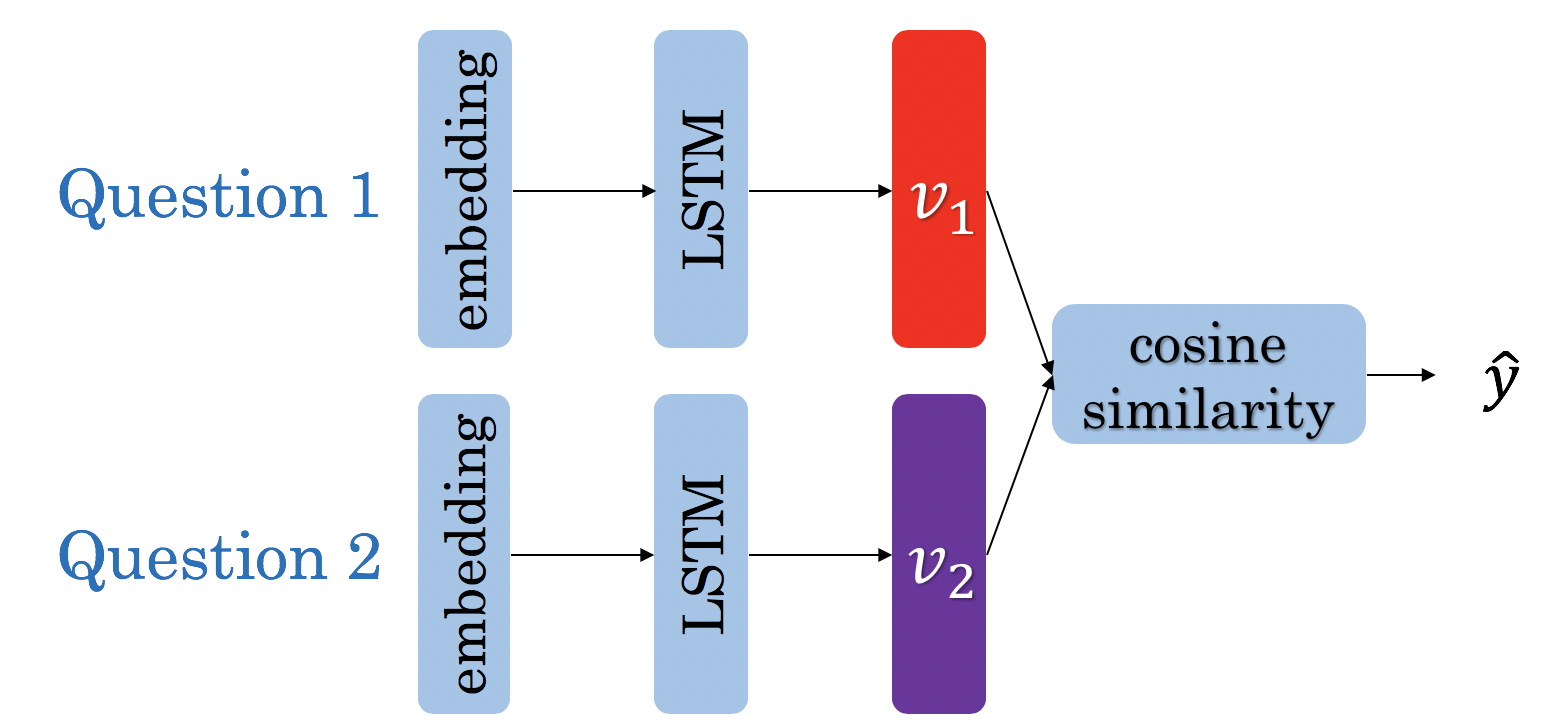



Vous obtenez l'embedding de la question, la faites passer par une couche LSTM, normalisez $v_1$ et $v_2$, et enfin utilisez une fonction de coût triplet (expliquée ci-dessous) pour obtenir la similarité cosinusoïdale correspondante pour chaque paire de questions. Comme d'habitude, vous commencerez par importer l'ensemble des données. La fonction de coût triplet utilise une entrée de base (anchor) qui est comparée à une entrée positive (vérité) et une entrée négative (fausse). La distance entre l'entrée de base (anchor) et l'entrée positive (vérité) est réduite au minimum, et la distance entre l'entrée de base (anchor) et l'entrée négative (fausse) est maximisée. Dans les équations mathématiques, vous essayez de maximiser ce qui suit.

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right)$$

$A$ est l'entrée de l'anchor, par exemple $q1_1$, $P$ l'entrée en double, par exemple $q2_1$, et $N$ l'entrée négative (la question sans double), par exemple $q2_2$.<br>
$\alpha$ est une marge ; vous pouvez la considérer comme un filet de sécurité, ou comme la mesure dans laquelle vous voulez pousser les doublons à partir des non doublons. 
<br>

<a name='ex02'></a>
### Exercice 02

**Instructions:** Implémentez la fonction `Siamese` ci-dessous. Vous devriez utiliser tous les objets expliqués ci-dessous. 

Pour implémenter ce modèle, vous utiliserez `trax`. Concrètement, vous utiliserez les fonctions suivantes.


- Série `tl.Serial` : Le combinateur qui applique les couches en série (par composition de fonction) vous permet de mettre en place la structure globale du feedforward. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial) / [code source](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/combinators.py#L26)
    - Vous pouvez passer les couches en argument à "Série", séparées par des virgules. 
    - Par exemple : `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))` 


- "l.Embedding" : Carte des jetons discrets aux vecteurs. Il aura une forme (longueur de vocabulaire X dimension des vecteurs de sortie). La dimension des vecteurs de sortie (également appelée d_feature) est le nombre d'éléments dans le mot embedding. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding) / [code source](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L113)
    - `tl.Embedding(vocab_size, d_feature)`.
    - La "taille_du_vocab" est le nombre de mots uniques dans le vocabulaire donné.
    - d_feature` est le nombre d'éléments dans l'encastrement du mot (certains choix pour une taille d'encastrement du mot vont de 150 à 300, par exemple).


- tl.LSTM` La couche LSTM. Elle exploite une autre couche Trax appelée [`LSTMCell`] (https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTMCell). Le nombre d'unités doit être spécifié et doit correspondre au nombre d'éléments dans l'encapsulation du mot. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM) / [code source](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/rnn.py#L87)
    - LSTM(n_unités)` Construit une couche LSTM de n_unités.
    
    
- `tl.Mean` : Calcule la moyenne sur l'axe désiré. La moyenne utilise un axe tenseur pour former des groupes de valeurs et remplace chaque groupe par la valeur moyenne de ce groupe. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Mean) / [code source](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L276)
    - `tl.Mean(axis=1)` moyenne sur les colonnes.


- `tl.Fn` Couche sans poids qui applique la fonction f, qui doit être spécifiée en utilisant une syntaxe lambda. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn) / [source doce](https://github.com/google/trax/blob/70f5364dcaf6ec11aabbd918e5f5e4b0f5bfb995/trax/layers/base.py#L576)
    - $x$ -> Ceci est utilisé pour la similarité du cosinus.
    - l.Fn('Normalize', lambda x : normalize(x))` Retourne un calque sans poids qui applique la fonction `f`.
    
    
- "l.parallel" : Il s'agit d'une couche combinatoire (comme "série") qui applique une liste de couches en parallèle à ses entrées. [docs](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Parallel) / [code source](https://github.com/google/trax/blob/37aba571a89a8ad86be76a569d0ec4a46bdd8642/trax/layers/combinators.py#L152)


In [ ]:
def Siamese(vocab_size=len(vocab), d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    q_processor = tl.Serial(  # Processor will run on Q1 and Q2.
        None, # Embedding layer
        None, # LSTM layer
        None, # Mean over columns
        None  # Apply normalize function
    )  # Returns one vector of shape [batch_size, d_model].
    
    ### END CODE HERE ###
    
    # Run on Q1 and Q2 in parallel.
    model = tl.Parallel(q_processor, q_processor)
    return model


Mise ne place du Siamese network model

In [ ]:
# check your model
model = Siamese()
print(model)

**Expected output:**  

```CPP
Parallel_in2_out2[
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
]
```

<a name='2.2'></a>

### 2.2 Hard negative mining


Vous allez maintenant mettre en œuvre le `TripletLoss`.
Le coût est composée de deux termes. L'un des termes utilise la moyenne de toutes les valeurs non doubles, l'autre utilise la valeur négative la plus proche. Notre fonction de coût est donc :
 
\begin{align}
 \mathcal{Loss_1(A,P,N)} &=\max \left( -cos(A,P) + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_2(A,P,N)} &=\max \left( -cos(A,P) + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\\
\end{align}


En outre, deux séries d'instructions sont fournies. Le premier ensemble fournit une brève description de la tâche. Si cette description s'avère insuffisante, un ensemble plus détaillé peut être affiché.  

<a name='ex03'></a>
### Exercice 03

**Instructions (brèves):** Voici une liste de choses à faire : <br>

- Comme cela sera exécuté dans trax, utilisez `fastnp.xyz` lorsque vous utilisez une fonction `xyz` numpy
- Utilisez `fastnp.dot` pour calculer la matrice de similarité $v_1v_2^T$ de la dimension `batch_size` x `batch_size`.
- Prenez le score des doublons sur la diagonale `fastnp.diagonal`.
- Utilisez les fonctions `trax` `fastnp.eye` et `fastnp.maximum` pour la matrice d'identité et le maximum.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Instructions plus détaillées </b></font>
</summary>
Nous allons décrire l'algorithme à l'aide d'un exemple détaillé. Ci-dessous, V1, V2 sont les sorties des blocs de normalisation de notre modèle. Nous utiliserons ici un batch_size de 4 et un d_modèle de 3. Comme expliqué dans l'exposé, les entrées, Q1, Q2 sont disposées de telle sorte que les entrées correspondantes sont des doublons alors que les entrées non correspondantes ne le sont pas. Les sorties auront le même modèle.

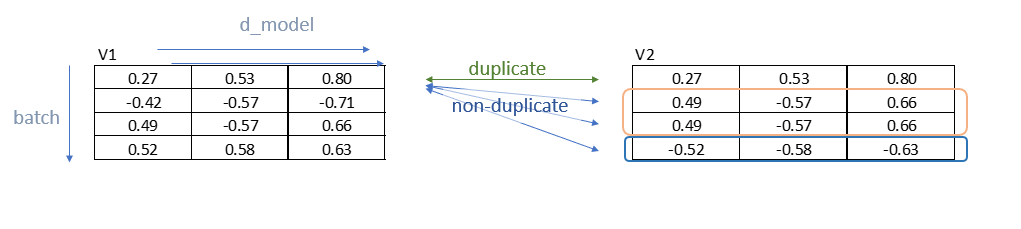

Ce cas de test organise les sorties, v1,v2, pour mettre en évidence différents scénarios. Ici, les deux premières sorties V1[0], V2[0] correspondent exactement - le modèle génère donc le même vecteur pour les entrées Q1[0] et Q2[0]. Les secondes sorties diffèrent, encerclées en orange, nous avons fixé, V2 [1] correspond à V2 [**2**], simulant un modèle qui génère de très mauvais résultats. V1[3] et V2[3] correspondent à nouveau exactement, tandis que V1[4] et V2[4] sont réglés pour être exactement faux - à 180 degrés l'un de l'autre, encerclés en bleu. 

La première étape consiste à calculer la matrice de similarité cosinusoïdale ou "score" dans le code. Comme expliqué dans la conférence, il s'agit de $$V_1 V_2^T$$$ Ceci est généré avec `fastnp.dot`.

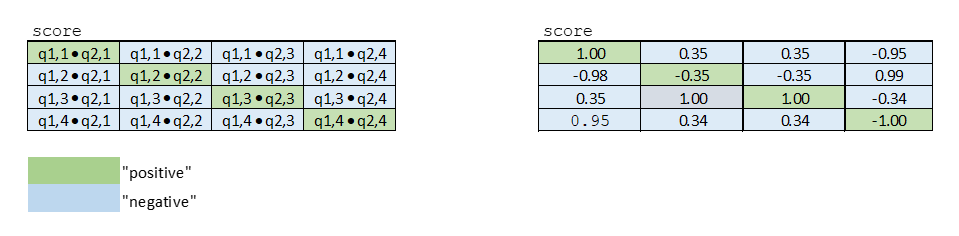

La disposition intelligente des entrées crée les données nécessaires pour les exemples positifs *et* négatifs sans avoir à exécuter toutes les combinaisons par paires. Comme Q1[n] est un double de Q2[n] seulement, les autres combinaisons sont explicitement créées des exemples négatifs ou des exemples *durément négatifs*. La multiplication matricielle produit efficacement la similarité en cosinus de toutes les combinaisons positives/négatives comme indiqué ci-dessus sur le côté gauche du diagramme. Les "positifs" sont les résultats des exemples dupliqués et les "négatifs" sont les résultats des exemples négatifs créés explicitement. Les résultats de notre cas test sont conformes aux attentes, la correspondance V1[0]V2[0] produisant un "1" tandis que nos autres cas "positifs" (en vert) ne correspondent pas bien, comme cela a été arrangé. La V2[2] a été configurée pour correspondre à la V1[3], ce qui donne une mauvaise correspondance au "score [2,2]" et un cas "négatif" non souhaité de "1" affiché en gris. 

Avec la matrice de similarité (`score`), nous pouvons commencer à mettre en œuvre les équations de perte. Tout d'abord, nous pouvons extraire $$cos(A,P)$$ en utilisant `fastnp.diagonal`. Le but est de saisir toutes les entrées vertes du diagramme ci-dessus. C'est "positif" dans le code.

Ensuite, nous allons créer le *plus proche_négatif*. C'est l'entrée non doublon de V2 qui est la plus proche (a la plus grande similarité de cosinus) d'une entrée de V1. Chaque ligne, n, du `score` représente toutes les comparaisons des résultats de Q1[n] par rapport à Q2[x] dans un lot. Un exemple spécifique dans notre cas de test est la ligne `score[2, :]`. Elle présente la similitude de cosinus de V1[2] et V2[x]. Le *plus proche_négatif*, comme cela a été arrangé, est V2[2] qui a un score de 1. C'est la valeur maximale des entrées "négatives" (entrées bleues dans le diagramme).

Pour cela, nous devons choisir l'entrée maximale sur une ligne de "score", en ignorant les entrées "positives"/vertes. Pour éviter de sélectionner les entrées "positives"/vertes, nous pouvons leur attribuer des nombres négatifs plus importants. Multipliez `fastnp.eye(batch_size)` par 2.0 et soustrayez-le des `scores`. Le résultat est `négatif_sans_positif`. Maintenant, nous pouvons utiliser `fastnp.max`, ligne par ligne (axe=1), pour sélectionner le maximum qui est `le plus proche_négatif`.

Ensuite, nous allons créer *moyen_négatif*. Comme son nom l'indique, c'est la moyenne de toutes les valeurs 'négatives'/bleues dans `score` sur une base ligne par ligne. Nous pouvons utiliser `fastnp.eye(batch_size)` et une constante, cette fois pour créer un masque avec des zéros sur la diagonale. Pour chaque élément, multipliez cela par le `score` pour obtenir uniquement les "valeurs négatives". C'est `négatif_zero_sur_duplicata` dans le code. Calculez la moyenne en utilisant `fastnp.sum` sur `negative_zero_on_duplicate` pour `axis=1` et divisez-la par `(batch_size - 1)` . C'est la `moyenne_négative`.

Maintenant, nous pouvons calculer la perte en utilisant les deux équations ci-dessus et `fastnp.maximum`. Ceci formera `triplet_loss1` et `triplet_loss2`. 

La "perte triple" est la "moyenne rapide" de la somme des deux pertes individuelles.


 
<\details>  

In [ ]:
def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function.

    Args:
        v1 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        jax.interpreters.xla.DeviceArray: Triplet Loss.
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    
    # use fastnp to take the dot product of the two batches (don't forget to transpose the second argument)
    scores = None  # pairwise cosine sim
    # calculate new batch size
    batch_size = len(scores)
    # use fastnp to grab all postive `diagonal` entries in `scores`
    positive = None  # the positive ones (duplicates)
    # multiply `fastnp.eye(batch_size)` with 2.0 and subtract it out of `scores`
    negative_without_positive = None
    # take the row by row `max` of `negative_without_positive`. 
    # Hint: negative_without_positive.max(axis = [?])  
    closest_negative = None
    # subtract `fastnp.eye(batch_size)` out of 1.0 and do element-wise multiplication with `scores`
    negative_zero_on_duplicate = None
    # use `fastnp.sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)` 
    mean_negative = None
    # compute `fastnp.maximum` among 0.0 and `A`
    # A = adding `positive` and `closest_negative`, and subtracting them out of `margin` 
    triplet_loss1 = None
    # compute `fastnp.maximum` among 0.0 and `B`
    # B = adding `positive` and `mean_negative`, and subtracting them out of `margin`
    triplet_loss2 = None
    # add the two losses together and take the `fastnp.mean` of it
    triplet_loss = None
    
    ### END CODE HERE ###
    
    return triplet_loss

In [ ]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
TripletLossFn(v2,v1)
print("Triplet Loss:", TripletLossFn(v2,v1))

**Expected Output:**
```CPP
Triplet Loss: 0.5
```   

Pour créer une couche à partir d'une fonction sans entraîner les variables entraînables, utilisez `tl.Fn`.

In [ ]:
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

<a name='3'></a>

# Partie 3 : L'entraînement

Maintenant, vous allez entraîner votre modèle. Comme d'habitude, vous devez définir la fonction de coût et l'optimiseur. Vous devez également alimenter le modèle construit. Avant d'entamer l'entraînement, nous utiliserons un ensemble de données spécial. Nous définirons les entrées à l'aide du générateur de données que nous avons construit ci-dessus. La fonction lambda agit comme un seed pour se souvenir du dernier lot qui a été donné. Lancez la cellule ci-dessous pour obtenir les entrées des paires de questions. 

In [ ]:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)

<a name='3.1'></a>

### 3.1 Entraînement du modèle

Vous allez maintenant écrire une fonction qui prend en compte votre modèle et l'entraîne. Pour entraîner votre modèle, vous devez décider combien de fois vous voulez itérer sur l'ensemble des données ; chaque itération est définie comme une `epoch`. Pour chaque epoch, vous devez passer en revue toutes les données, en utilisant votre itérateur d'entraînement.

<a name='ex04'></a>
### Exercice 04

**Instructions:** Implémenter le `modèle_de_formation` ci-dessous pour entraîner le réseau neuronal au-dessus. Voici une liste de choses à faire : 

- Créer des `TrainTask` et des `EvalTask`.
- Créer la boucle d'entraînement `trax.supervised.training.Loop`.
- Passez à la suite selon le contexte (train_task ou eval_task) :
    - `labeled_data=generator` (données étiquetées)
    - `metrics=[TripletLoss()]`,
    - `loss_layer=TripletLoss()`
    - `optimizer=trax.optimizers.Adam` avec un learning rate de 0,01
    - `lr_schedule=lr_schedule`,
    - `output_dir=output_dir``.


Vous utiliserez votre fonction de coût de triplets avec Adam optimizer. Veuillez lire la documentation [trax](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html?highlight=adam#trax.optimizers.adam.Adam) pour en avoir une compréhension complète. 

Cette fonction devrait retourner un objet "training.Loop". Pour en savoir plus, consultez la documentation [docs](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html?highlight=loop#trax.supervised.training.Loop).

In [ ]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator, val_generator=val_generator, output_dir='model/'):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        lr_schedule (function): Trax multifactor schedule function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    output_dir = os.path.expanduser(output_dir)

    ### START CODE HERE (Replace instances of 'None' with your code) ###

    train_task = training.TrainTask(
        labeled_data=None,       # Use generator (train)
        loss_layer=None,         # Use triplet loss. Don't forget to instantiate this object
        optimizer=None,          # Don't forget to add the learning rate parameter
        lr_schedule=lr_schedule, # Use Trax multifactor schedule function
    )

    eval_task = training.EvalTask(
        labeled_data=None,       # Use generator (val)
        metrics=[None],          # Use triplet loss. Don't forget to instantiate this object
    )
    
    ### END CODE HERE ###

    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_tasks=eval_task,
                                  output_dir=output_dir)

    return training_loop

In [ ]:
train_steps = 5
training_loop = train_model(Siamese, TripletLoss, lr_schedule)
training_loop.run(train_steps)

Le modèle n'a été entraîné que pour 5 étapes en raison des contraintes de cet environnement. Pour le reste de la mission, vous utiliserez un modèle préentraîné, mais vous devez maintenant comprendre comment l'entraînement peut être effectuée.


# Partie 4 : Évaluation  


### 4.1 Evaluer votre réseau siamois

Dans cette section, vous apprendrez comment évaluer un réseau siamois. Vous commencerez par charger un modèle préentraîné et vous l'utiliserez ensuite pour faire des prévisions. 

In [ ]:
# Loading in the saved model
model = Siamese()
model.init_from_file('gdrive/MyDrive/TP_10/model_2.pkl.gz')

<a name='4.2'></a>
### 4.2 Classifier
Pour déterminer la précision du modèle, nous utiliserons le jeu de tests qui a été configuré précédemment. Bien que nous n'ayons utilisé que des exemples positifs lors de la formation, les données du test, Q1_test, Q2_test et y_test, sont configurées comme des paires de questions, dont certaines sont des doublons et d'autres non. 
Cette routine va faire passer toutes les paires de questions du test par le modèle, calculer la similitude en cosinus de chaque paire, la seuiller et comparer le résultat à y_test - la réponse correcte de l'ensemble de données. Les résultats sont cumulés pour produire une précision.


<a name='ex05'></a>
### Exercice 05

**Instructions**  
 - Passez en boucle les données entrantes par lots
 - Utilisez le générateur de données pour charger q1, q2 un lot à la fois. **N'oubliez pas de régler shuffle=False !
 - copier un morceau de y de la taille d'un lot dans y_test
 - calculer v1, v2 en utilisant le modèle
 - pour chaque élément du lot
        - calculer la similarité des coûts de chaque paire d'entrées, v1[j],v2[j]
        - déterminer si d > seuil
        - augmentation de la précision si ce résultat correspond aux résultats attendus (y_test[j])
 - calculer l'exactitude et le rendement final
 
En raison de certaines limitations de cet environnement, l'exécution de classifications à plusieurs reprises peut entraîner l'échec du noyau. Si cela se produit, *Redémarrez Kernal & effacez la sortie* et exécutez ensuite à partir du haut. Pendant le développement, envisagez d'utiliser un ensemble de données plus petit pour réduire le nombre d'appels à model(). 

In [ ]:
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """
    accuracy = 0
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    for i in range(0, len(test_Q1), batch_size):
        # Call the data generator (built in Ex 01) with shuffle=False using next()
        # use batch size chuncks of questions as Q1 & Q2 arguments of the data generator. e.g x[i:i + batch_size]
        # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
        q1, q2 = None
        # use batch size chuncks of actual output targets (same syntax as example above)
        y_test = None
        # Call the model
        v1, v2 = None

        for j in range(batch_size):
            # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
            # don't forget to transpose the second argument
            d = None
            # is d greater than the threshold?
            res = None
            # increment accurancy if y_test is equal `res`
            accuracy += None
    # compute accuracy using accuracy and total length of test questions
    accuracy = None
    ### END CODE HERE ###
    
    return accuracy

In [ ]:
# this takes around 1 minute
accuracy = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy)

**Expected Result**  
Accuracy ~0.72

<a name='5'></a>

# Partie 5 : Test avec vos propres questions

Dans cette section, vous testerez le modèle avec vos propres questions. Vous écrirez une fonction "prédire" qui prend deux questions comme entrée et renvoie 1$ ou 0$ selon que la paire de questions est un double ou non.   

Mais d'abord, nous construisons un vocabulaire inversé qui permet de faire correspondre les questions codées à des mots.

Rédigez une fonction `predict` qui prend en compte deux questions, le modèle et le vocabulaire, et renvoie si les questions sont des doublons (1) ou  non (0) compte tenu d'un seuil de similarité. 

<a name='ex06'></a>
### Exercice 06


**Instructions:** 
- Indiquez votre question en utilisant `nltk.word_tokenize`. 
- Créez des Q1,Q2 en encodant vos questions sous forme de liste de nombres en utilisant du vocabulaire
- pad Q1,Q2 avec next(data_generator([Q1], [Q2],1,vocab['<PAD>']))
- utiliser model() pour créer v1, v2
- calculer la similarité cosinus (produit des points) de v1, v2
- calculer res en comparant d au seuil


In [ ]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # use `nltk` word tokenize function to tokenize
    q1 = None  # tokenize
    q2 = None  # tokenize
    Q1, Q2 = [], []
    for word in q1:  # encode q1
        # increment by checking the 'word' index in `vocab`
        Q1 += None
    for word in q2:  # encode q2
        # increment by checking the 'word' index in `vocab`
        Q2 += None
        
    # Call the data generator (built in Ex 01) using next()
    # pass [Q1] & [Q2] as Q1 & Q2 arguments of the data generator. Set batch size as 1
    # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
    Q1, Q2 = None
    # Call the model
    v1, v2 = None
    # take dot product to compute cos similarity of each pair of entries, v1, v2
    # don't forget to transpose the second argument
    d = None
    # is d greater than the threshold?
    res = None
    
    ### END CODE HERE ###
    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

In [ ]:
# Feel free to try with your own questions
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose = True)

##### Expected Output
Si l'entrée est :
```CPP
question1 = "When will I see you?"
question2 = "When can I see you again?"
```

La sortie est (d peut varier un peu) :
```CPP
Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   33    4   46   53 7280   21    1]]
d   =  0.8621342
res =  True
True
```

In [ ]:
# Feel free to try with your own questions
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose=True)

##### Expected output

Si l'entrée est :
```CPP
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
```

Sortie (d peut varier un peu) :

```CPP
Q1  =  [[  443  1145  3159  1169    78 29017    21     1]] 
Q2  =  [[  443  1145    60 15302    28    78  7431    21]]
d   =  0.5678078
res =  False
False
```

Vous pouvez voir que le réseau siamois est capable de comprendre des structures compliquées. Concrètement, il peut identifier les doublons de questions, bien que les questions n'aient pas beaucoup de mots en commun. 
 

### <span style="color:blue"> Sur les réseaux siamois </span>

Les réseaux siamois sont importants et utiles. Souvent, plusieurs questions sont déjà posées dans quora, ou d'autres plateformes, et vous pouvez utiliser les réseaux siamois pour éviter les doublons de questions. 

